<a href="https://colab.research.google.com/github/juba/StableDiffusionNotebook/blob/main/Stable_Diffusion_custom_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stable Diffusion custom notebook

Sources : 

- https://github.com/CompVis/stable-diffusion
- https://huggingface.co/CompVis/stable-diffusion-v1-4
- https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb


# 1. Setup

In [1]:
#@title 1.1 Check allocated GPU
!nvidia-smi

Sun Aug 28 13:36:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#@title 1.2 Install Python dependencies
!pip install diffusers==0.2.4
!pip install transformers scipy ftfy
!pip install "ipywidgets>=7,<8"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 112 kB 8.3 MB/s 
     |████████████████████████████████| 120 kB 50.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 7.8 MB/s 
     |████████████████████████████████| 53 kB 1.7 MB/s 
     |████████████████████████████████| 6.6 MB 38.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 8.6 MB/s 


In [3]:
#@title 1.3 Logging in to Huggingface Hub
from google.colab import output
output.enable_custom_widget_manager()

from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [4]:
#@title 1.4 Downloading model
import torch
from diffusers import StableDiffusionPipeline

use_float16_precision = False#@param {type:"boolean"}


# make sure you're logged in with `huggingface-cli login`
if use_float16_precision:
  pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", 
    revision="fp16", torch_dtype=torch.float16, 
    use_auth_token=True
  )
else:
  pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", 
    use_auth_token=True
  )

Downloading:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/592 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/71.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [49]:
#@title 1.5 Utility code and functions

from PIL import Image
from torch import autocast
import random

# Move pipeline to GPU
pipe = pipe.to("cuda")

# Image grid utility
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


# Do diffusion
def do_diffuse(pipe, params):
  
  num_images = params['images_rows'] * params['images_cols']
  prompt = params['prompt'] * num_images

  seed = params['seed']
  if seed == -1:
    random.seed()
    seed = random.randint(0, 2**32)

  generator = torch.Generator("cuda").manual_seed(seed)

  with autocast("cuda"):
    out = pipe(
        prompt,
        num_inference_steps=params['num_inference_steps'],
        guidance_scale=params['guidance_scale'],
        width=params['width'],
        height=params['height'],
        generator=generator
    )["sample"]
  
  if num_images > 1:
    out = image_grid(out, rows=params['images_rows'], cols=params['images_cols'])
  else:
    out = out[0]

  return (out, seed)



In [46]:
#@title 1.6 Google Drive
import os
import json
from glob import glob

use_google_drive = True #@param{type: 'boolean'}

if use_google_drive:
  from google.colab import drive
  drive.mount('/content/drive')
  root_path = '/content/drive/MyDrive/AI/Stable_Diffusion'
  # Output dir
  outDirPath = f'{root_path}/images_out'
  os.makedirs(outDirPath, exist_ok=True)
  # Index for file names
  file_count = len(glob(outDirPath+"/*.txt")) + 1


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Generate images


In [51]:
#@title 2.1 Settings

num_inference_steps = 50 #@param{type: 'number'}
guidance_scale = 8 #@param{type: 'number'}
width = 512 #@param{type: 'number'}
height = 512 #@param{type: 'number'}
images_rows = 1 #@param{type: 'number'}
images_cols = 1 #@param{type: 'number'}
seed = -1 #@param{type: 'number'}

params = {
    'num_inference_steps': num_inference_steps,
    'guidance_scale': guidance_scale,
    'width': width,
    'height': height,
    'images_rows': images_rows,
    'images_cols': images_cols,
    'use_float16': use_float16_precision,
    'seed': seed
}

In [33]:
prompt = "selfie of a teletubby in the cockpit of a fighter jet"

0it [00:00, ?it/s]

Using seed : 3595654672


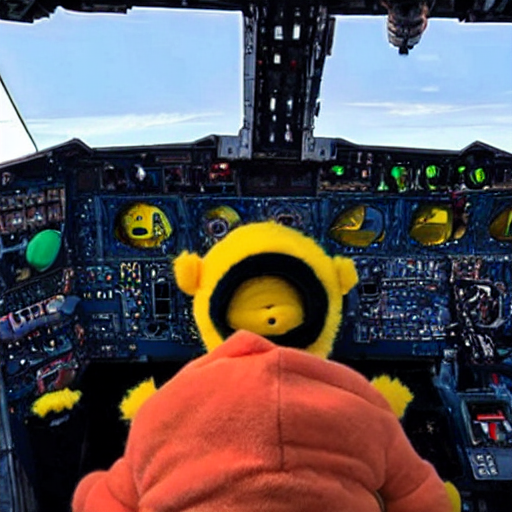

In [52]:
#@title 2.2 Diffuse

params['prompt'] = prompt
image, seed = do_diffuse(pipe, params)

if use_google_drive:
  # Increment index
  file_count += 1
  # Save settings
  params['seed'] = seed
  with open(f"{outDirPath}/img{file_count}_settings.txt", "w+") as f:   #save settings
        json.dump(params, f, ensure_ascii=False, indent=4)
  # Save image
  image.save(f"{outDirPath}/img{file_count}.jpg")
  

print(f"Using seed : {seed}")
display(image)